In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [28]:
df = pd.read_csv('../data/background_music.csv', dtype={'CondOfSubj':'category'})

In [39]:
music = {0: 'Das Kruschke', 1: 'Mozart', 2: 'Bach', 3: 'Beethoven'}

In [40]:
df['CondText'] = df.CondOfSubj.cat.codes.map(music)

In [41]:
df.head()

,CondOfSubj,nTrlOfSubj,nCorrOfSubj,CondText
0,1,20,8,Das Kruschke
1,1,20,7,Das Kruschke
2,1,20,8,Das Kruschke
3,1,20,6,Das Kruschke
4,1,20,7,Das Kruschke


### Are the different groups equal or not?

In [42]:
df.groupby('CondText', sort=False)['nCorrOfSubj'].sum()

CondText
Das Kruschke    160
Mozart          200
Bach            204
Beethoven       208
Name: nCorrOfSubj, dtype: int64

In [61]:
cond_idx = df.CondOfSubj.cat.codes.values
cond_codes = df.CondOfSubj.cat.categories
nCond = cond_codes.size

nSubj = df.index.size

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
CondOfSubj     80 non-null category
nTrlOfSubj     80 non-null int64
nCorrOfSubj    80 non-null int64
CondText       80 non-null object
dtypes: category(1), int64(2), object(1)
memory usage: 2.1+ KB


Model 0 - Condition specific

Model 1 - Same $\omega$ for all attributes

In [62]:
import theano.tensor as tt

In [68]:
with pm.Model() as model:
    # constants
    aP, bP = 1., 1.
    
    # Pseudo- and true priors for model 1.  
    a0 = tt.as_tensor([.48*500, aP])      
    b0 = tt.as_tensor([(1-.48)*500, bP])
    
    # True and pseudopriors for model 0
    a = tt.as_tensor(np.c_[np.tile(aP, 4), [(.40*125), (.50*125), (.51*125), (.52*125)]])
    b = tt.as_tensor(np.c_[np.tile(bP, 4), [(1-.40)*125, (1-.50)*125, (1-.51)*125, (1-.52)*125]])        
  
    # Prior on model index [0,1]
    m_idx = pm.Categorical('m_idx', np.asarray([.5, .5]))
    
    # Priors on concentration parameters
    kappa_minus2 = pm.Gamma('kappa_minus2', 2.618, 0.0809, shape=nCond)
    kappa = pm.Deterministic('kappa', kappa_minus2 +2)
        
    # omega0 
    omega0 = pm.Beta('omega0', a0[m_idx], b0[m_idx])    
        
    # omega (condition specific)
    omega = pm.Beta('omega', a[:,m_idx], b[:,m_idx], shape=nCond)
    
    # Use condition specific omega when m_idx = 0, else omega0
    aBeta = pm.math.switch(pm.math.eq(m_idx, 0), omega * (kappa-2)+1, omega0 * (kappa-2)+1)
    bBeta = pm.math.switch(pm.math.eq(m_idx, 0), (1-omega) * (kappa-2)+1, (1-omega0) * (kappa-2)+1)

    # Theta
    theta = pm.Beta('theta', aBeta[cond_idx], bBeta[cond_idx], shape=nSubj)
    
    # Likelihood
    y = pm.Binomial('y', n=df.nTrlOfSubj.values, p=theta, observed=df.nCorrOfSubj)

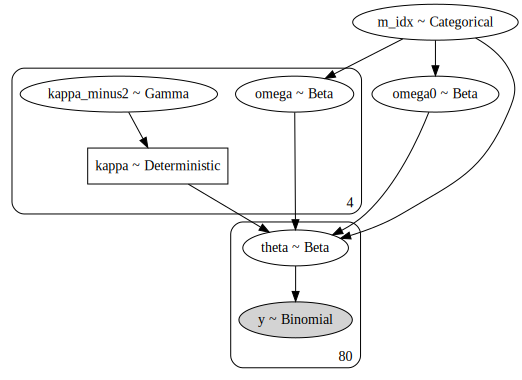

In [69]:
pm.model_to_graphviz(model)

In [70]:
with model:
    trace = pm.sample(5000, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m_idx]
>NUTS: [theta, omega, omega0, kappa_minus2]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:32<00:00, 672.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x132656b00>,
      dtype=object)

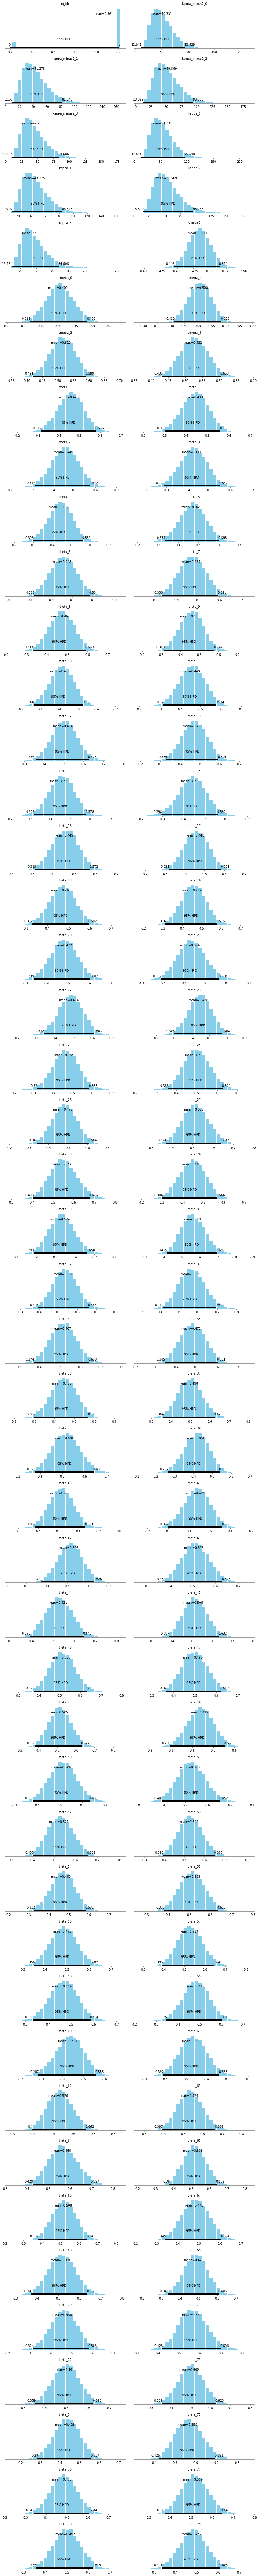

In [71]:
pm.plot_posterior(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ff355f8>,
      dtype=object)

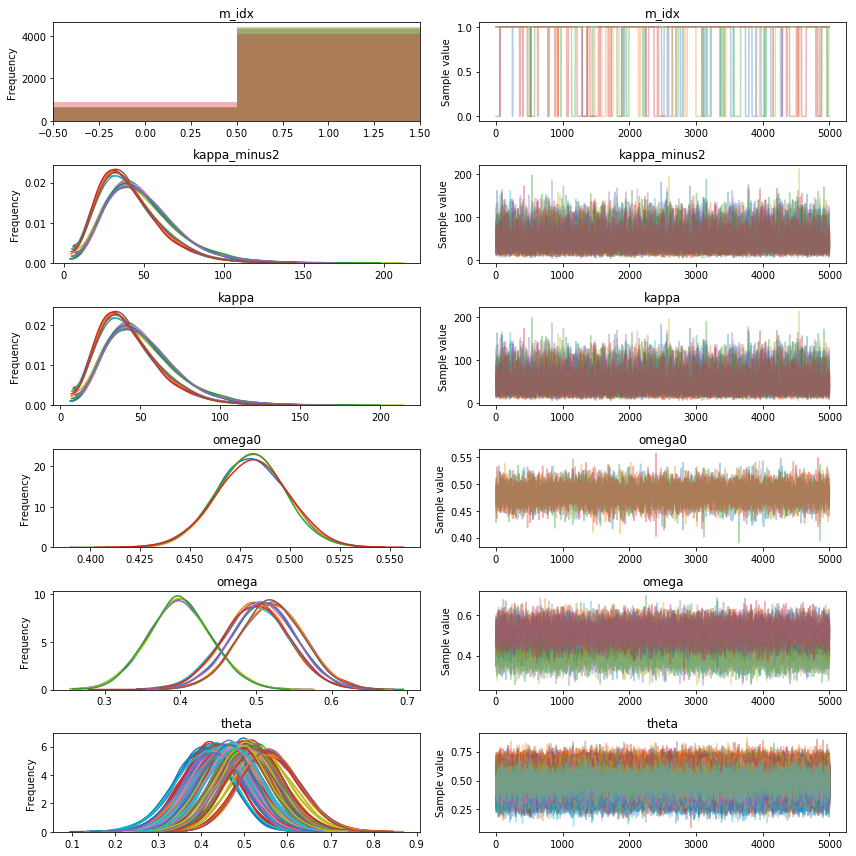

In [72]:
pm.traceplot(trace)

In [78]:
from matplotlib import gridspec
color = '#87ceeb'

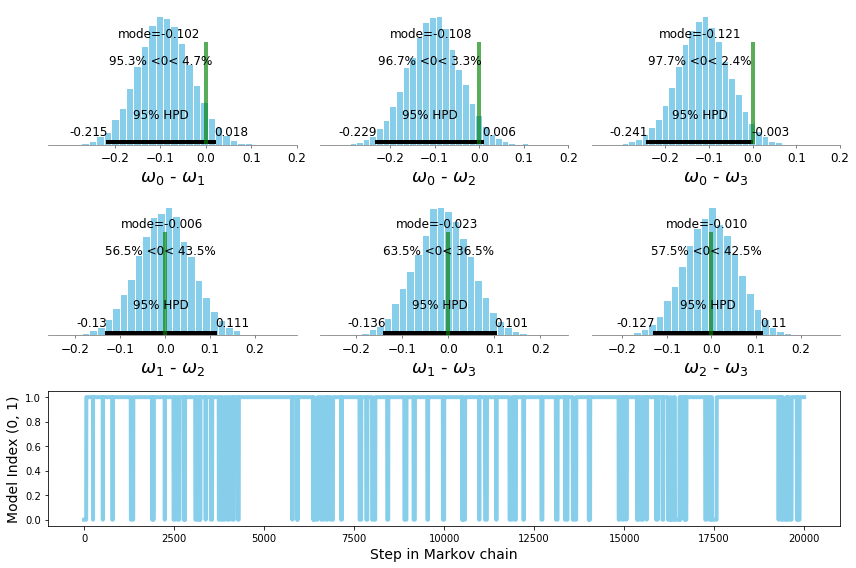

In [79]:
fig = plt.figure(figsize=(12,8))

# Define gridspec
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])
ax7 = plt.subplot(gs[2,:])

# Group the first six axes in a list for easier access in loop below
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
# Differences of posteriors to be displayed: omega x - omega y
x = [0,0,0,1,1,2]
y = [1,2,3,2,3,3]

# Plot histograms
for ax, a, b in zip(axes, x, y):
    diff = trace['omega'][:,a]-trace['omega'][:,b]
    pm.plot_posterior(diff, ref_val=0, point_estimate='mode', color=color, ax=ax)
    ax.set_xlabel('$\omega_{}$ - $\omega_{}$'.format(a,b), fontdict={'size':18})
    ax.xaxis.set_ticks([-.2, -.1, 0.0, 0.1, 0.2])

# Plot trace values of model index (0, 1)
ax7.plot(np.arange(1, len(trace['m_idx'])+1),trace['m_idx'], color=color, linewidth=4)
ax7.set_xlabel('Step in Markov chain', fontdict={'size':14})
ax7.set_ylabel('Model Index (0, 1)', fontdict={'size':14})
ax7.set_ylim(-0.05,1.05)


fig.tight_layout()